# ML HW3 Sample Code
TODO:
 - Design your AutoEncoder model
 - Pre-train with unlabelled data
    - Augmentation
 - Fine-tune with labelled data
    - Augmentation
    - Loss function

Report:
 - Clustering
    - Implement Equilibrium K-means algorithm
    - t-SNE : Show the embedding of different classes
 - Anomaly detection
    - Reconstruct unseen classes

## Download data

In [1]:
# !gdown 1Bw1ksB6AkTICynIHHkG7NKAdf3sBI1uR
!gdown 1kO12YQxqGFLbY3WiskJyYG7S-hiPae24
!unzip -q 'hw3.zip'

Downloading...
From (original): https://drive.google.com/uc?id=1kO12YQxqGFLbY3WiskJyYG7S-hiPae24
From (redirected): https://drive.google.com/uc?id=1kO12YQxqGFLbY3WiskJyYG7S-hiPae24&confirm=t&uuid=58e71673-9d9d-433a-bab6-5b67e1789a59
To: /kaggle/working/hw3.zip
100%|████████████████████████████████████████| 196M/196M [00:02<00:00, 96.2MB/s]


## Import packages

In [2]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision as tv

import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

## Datasets and Dataloaders

In [3]:
def load_unlabelled(img_dir):
    return  [ Image.open(os.path.join(img_dir, str(i)+'.jpg')) for i in range(len(os.listdir(img_dir))) ]


def load_labelled(root_dir):
    data = []
    labels = []
    for label in os.listdir(root_dir):
        for img in os.listdir(os.path.join(root_dir, label)):
            img = Image.open(os.path.join(root_dir, label, img))
            data.append(img)
            labels.append(int(label))
    return [*zip(data, labels)]

class ImageDataset(Dataset):
    def __init__(self, imgs, labels=None, tfm=T.ToTensor()):
        super().__init__()
        self.imgs = imgs
        self.labels = labels
        self.tfm = tfm
    def __getitem__(self, idx):
        if self.labels is None:
            return self.tfm(self.imgs[idx])
            # return nn.AvgPool2d(2,2)(self.tfm(self.imgs[idx]))
        else:
            return self.tfm(self.imgs[idx]), self.labels[idx]
            # return nn.AvgPool2d(2,2)(self.tfm(self.imgs[idx])), self.labels[idx]
    def __len__(self):
        return len(self.imgs)

## AutoEncoder model
<span style="color:orange">(TODO: Design your model)</span>

<img src="https://julien-vitay.net/lecturenotes-neurocomputing/_images/semisupervised-autoencoder.png" width="500"/>

In [4]:
# TODO: Implement your autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(start_dim=1),   # Flatten to feed into the linear layer
            nn.Linear(512*4*4, 1024)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(1024, 512*4*4),
            nn.Unflatten(dim=1, unflattened_size=(512, 4, 4)),   # Unflatten
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Use sigmoid to get pixel values between 0 and 1
        )

        # classifier head
        self.predictor = nn.Sequential(
            nn.Linear(1024, 1024),   # Latent space with 1024 features
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        # encode
        z = self.encoder(x)
        # decode
        x_prime = self.decoder(z)
        # classify
        y = self.predictor(z)
        return x_prime, y, z

## Pre-train with unlabelled data
<span style="color:orange">(TODO: Hyperparameter tuning / Augmentation)</span>

In [5]:
def add_noise(x, noise_factor=0.1):
    noise = noise_factor * torch.randn_like(x)
    return x + noise

def pretrain(model, train_loader, valid_loader, config, noise_function=add_noise):
    model = model.to(config.device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_valid_loss = 1e9
    for epoch in range(config.pretrain_epochs):
        model.train()
        train_loss = 0
        for img in tqdm(train_loader):
            img = img.to(config.device)
            optimizer.zero_grad()
            output, _, _ = model(noise_function(img, config.noise_factor))
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        if valid_loader is not None:
            model.eval()
            valid_loss = 0
            with torch.no_grad():
                for img in valid_loader:
                    img = img.to(config.device)
                    output, _, _ = model(img)
                    loss = criterion(output, img)
                    valid_loss += loss.item()
                valid_loss /= len(valid_loader)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), config.pretrain_model_path)

            print(f'Epoch {epoch+1}/{config.pretrain_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

In [6]:
# TODO: Determine your hyperparameters and augmentation for pretraining
pretrain_train_tfm = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=30, scale=(0.90, 1.1)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05),
    T.ToTensor(),
])
pretrain_valid_tfm = T.Compose([
    T.ToTensor()
])

pretrain_config = Namespace(
    batch_size = 256,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr = 1e-3,
    weight_decay = 0,
    noise_factor = 0.01,
    pretrain_epochs = 10,
    pretrain_model_path = 'pretrain_model.ckpt'
)

In [7]:
pretrain_train_data = load_unlabelled('data/dev/unlabelled')
pretrain_train_data, pretrain_valid_data = torch.utils.data.random_split(pretrain_train_data, [0.8, 0.2])
pretrain_train_dataset, pretrain_valid_dataset = ImageDataset(pretrain_train_data, tfm=pretrain_train_tfm), ImageDataset(pretrain_valid_data, tfm=pretrain_valid_tfm)

pretrain_train_loader = DataLoader(pretrain_train_dataset, batch_size=pretrain_config.batch_size, shuffle=True)
pretrain_valid_loader = DataLoader(pretrain_valid_dataset, batch_size=pretrain_config.batch_size, shuffle=False)

In [ ]:
model = Autoencoder()
pretrain(model, pretrain_train_loader, pretrain_valid_loader, pretrain_config)

 15%|█▍        | 46/313 [04:19<27:58,  6.29s/it]

## Fine-tune with labelled data
<span style="color:orange">(TODO: Loss function / Augmentation)</span>

In [8]:
def loss_fn(x_prime, y, z, x, y_hat):
    # TODO: Define your loss function for fine-tuning
    # You might want to consider the reconstruction loss and/or the classification loss
    return nn.CrossEntropyLoss()(y, y_hat)

def finetune(model, train_loader, valid_loader, config, noise_function=add_noise):
    model = model.to(config.device)
    criterion = loss_fn
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_valid_loss = 1e9
    for epoch in range(config.finetune_epochs):
        model.train()
        train_loss, train_acc = 0, 0
        for img, label in tqdm(train_loader):
            img, label = img.to(config.device), label.to(config.device)
            optimizer.zero_grad()
            output = model(noise_function(img, config.noise_factor))
            loss = criterion(*output, img, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (output[1].argmax(dim=1) == label).float().mean().item()
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f'Epoch {epoch+1}/{config.finetune_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, label in valid_loader:
                img, label = img.to(config.device), label.to(config.device)
                output = model(img)
                loss = criterion(*output, img, label)
                valid_loss += loss.item()
                valid_acc += (output[1].argmax(dim=1) == label).float().mean().item()
            valid_loss /= len(valid_loader)
            valid_acc /= len(valid_loader)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), config.finetune_model_path)

        print(f'Epoch {epoch+1}/{config.finetune_epochs}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

In [9]:
# TODO: Determine your hyperparameters and augmentation for pretraining
finetune_train_tfm = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=30, scale=(0.90, 1.1)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05),
    T.ToTensor(),
])
finetune_valid_tfm = T.Compose([
    T.ToTensor()
])

finetune_config = Namespace(
    batch_size = 16,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr = 1e-3,
    weight_decay = 1e-7,
    noise_factor = 0.01,
    finetune_epochs = 20,
    finetune_model_path = 'finetune_model.ckpt'
)

In [10]:
finetune_train_data = load_labelled('data/dev/labelled')
finetune_train_data, finetune_valid_data = torch.utils.data.random_split(finetune_train_data, [0.8, 0.2])
finetune_train_dataset, finetune_valid_dataset = ImageDataset(*map(list, zip(*finetune_train_data)), finetune_train_tfm), ImageDataset(*map(list, zip(*finetune_valid_data)), finetune_valid_tfm)

finetune_train_loader = DataLoader(finetune_train_dataset, batch_size=finetune_config.batch_size, shuffle=True)
finetune_valid_loader = DataLoader(finetune_valid_dataset, batch_size=finetune_config.batch_size, shuffle=False)

In [ ]:
model = Autoencoder()
model.load_state_dict(torch.load(pretrain_config.pretrain_model_path))
finetune(model, finetune_train_loader, finetune_valid_loader, finetune_config)

## Testing

In [ ]:
test_dataset = ImageDataset(sorted(load_unlabelled('data/test'), key=lambda x: int(x.filename.split('/')[-1].split('.')[0])))
test_loader = DataLoader(test_dataset, batch_size=finetune_config.batch_size, shuffle=False)

model = Autoencoder()
model.load_state_dict(torch.load('finetune_model.ckpt'))
model = model.to(finetune_config.device).eval()

# Generate predictions
predictions = []
with torch.no_grad():
    for img in test_loader:
        img = img.to(finetune_config.device)
        _, y, _ = model(img)
        predictions.append(y.argmax(dim=1).cpu().numpy())
predictions = np.concatenate(predictions)

# Save predictions
with open('predict.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'label'])
    for id, r in enumerate(predictions):
        writer.writerow([id, r])

## Report

### Clustering
<span style="color:orange">(TODO: Implement the Equilibrium K-means algorithm)</span>
ref: https://arxiv.org/pdf/2402.14490

Distance between a data point $x_n$ and centroid $c_k$
$$d_{ik} = \frac{1}{2} \| x_i - c_k \|^2$$

Equation 38: Weight calculation
$$w_{kn}^{(\tau)} = \frac{e^{-\alpha d_{kn}^{(\tau)}}}{\sum_{i=1}^K e^{-\alpha d_{in}^{(\tau)}}}
\left[ 1 - \alpha \left( d_{kn}^{(\tau)} -
\frac{\sum_{i=1}^K d_{in}^{(\tau)} e^{-\alpha d_{in}^{(\tau)}}}{\sum_{i=1}^K e^{-\alpha d_{in}^{(\tau)}}}
\right) \right]$$

Equation 39: Centroid update
$$c_k^{(\tau+1)} = \frac{\sum_{n=1}^N w_{kn}^{(\tau)} x_n}{\sum_{n=1}^N w_{kn}^{(\tau)}}$$

<img src="https://dt5vp8kor0orz.cloudfront.net/5fedcaeba7180898deb71d026db359b0a56af6b3/9-Figure4-1.png" width="1000"/>

Final centroids:
 [[0.72195819 0.72810828]
 [0.69819817 2.10887713]
 [2.5452156  0.98400541]]
Real centroids:
 [[0.72414177 0.72703488]
 [0.6909491  2.05309247]
 [2.54522829 0.984031  ]]


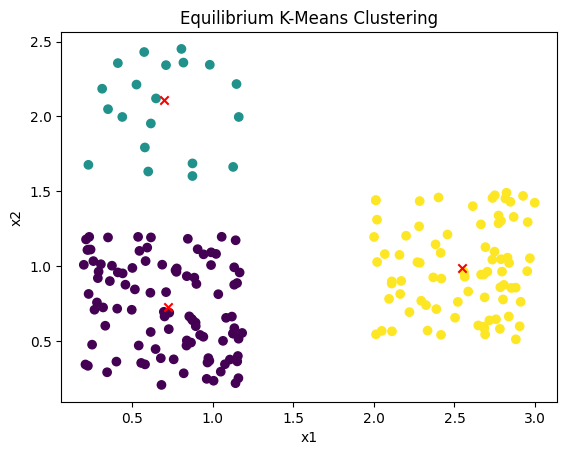

'\nX1 = np.random.rand(100, 2) + np.array([[0.2,0.2]])\nX2 = np.random.rand(20, 2) + np.array([[0.2,1.6]])\nX3 = np.random.rand(80, 2) + np.array([[2.0,0.5]])\nX = np.concatenate([X1, X2, X3])\n\nk = 3  # Number of clusters\nalpha = 10  # Smoothing parameter\nn_iter = 50  # Number of iterations\n\ncentroids = equilibrium_k_means(X, k, alpha, n_iter)\nprint("Final centroids:\n", centroids)\nprint("Real centroids:\n", np.array([np.mean(X1, axis=0), np.mean(X2, axis=0), np.mean(X3, axis=0)]))\n\n# Visualize the clustering - show the data points and the centroids\nclustering = select_clusters(Eq38_compute_weights(X, centroids, alpha))\nplot_clusters(X, centroids, clustering)'

In [39]:
import numpy as np

def equilibrium_k_means(X, k, alpha, n_iter):
    centroids = initialize_centroids(X, k) # Initialize centroids
    for _ in range(n_iter):
        weights = Eq38_compute_weights(X, centroids, alpha)  # Compute weights
        centroids = Eq39_update_centroids(X, weights)    # Update centroids
    return centroids

def initialize_centroids(X, k):
    # Initialize centroids as random samples
    return X[np.random.choice(X.shape[0], k, replace=False)]

def Eq38_compute_weights(X, centroids, alpha):
    #==== TODO: Compute the weights for each data point (refer to Eq. 38) ====#
    dist = 1/2*np.sum((np.expand_dims(X, axis=1)-centroids)**2,axis = 2)
    
    exp_term = np.exp(-alpha * dist)
    
    sum_exp = np.sum(exp_term, axis=1, keepdims=True)  # (N, 1)
    
    weighted_dist = np.sum(dist * exp_term, axis=1, keepdims=True) / sum_exp
    
    weights = (exp_term / sum_exp) * (1 - alpha * (dist - weighted_dist))
    
    return weights

def Eq39_update_centroids(X, weights):
    #==== TODO: Update the centroids (refer to Eq. 39) ====#

    centroids = np.dot(weights.T, X)/np.sum(weights,axis=0, keepdims=True).T
    #======================================================#
    return centroids

def select_clusters(weights):
    return np.argmax(weights, axis=1)

def plot_clusters(X, centroids, clustering, title='Equilibrium K-Means Clustering'):
    plt.scatter(X[:,0], X[:,1], c=clustering, cmap='viridis')
    plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='x')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()



X1 = np.random.rand(100, 2) + np.array([[0.2,0.2]])
X2 = np.random.rand(20, 2) + np.array([[0.2,1.6]])
X3 = np.random.rand(80, 2) + np.array([[2.0,0.5]])
X = np.concatenate([X1, X2, X3])

k = 3  # Number of clusters
alpha = 10  # Smoothing parameter
n_iter = 50  # Number of iterations

centroids = equilibrium_k_means(X, k, alpha, n_iter)
print("Final centroids:\n", centroids)
print("Real centroids:\n", np.array([np.mean(X1, axis=0), np.mean(X2, axis=0), np.mean(X3, axis=0)]))

# Visualize the clustering - show the data points and the centroids
clustering = select_clusters(Eq38_compute_weights(X, centroids, alpha))
plot_clusters(X, centroids, clustering)

# centroids = initialize_centroids(X,num_class)
# print(centroids.shape)
# weights = Eq38_compute_weights(X, centroids, alpha=0.1)
# centroids_update = Eq39_update_centroids(X, weights)
# print(centroids_update.shape)
# clustering = select_clusters(weights)
# plot_clusters(X, centroids, clustering)

# Example usage
'''
X1 = np.random.rand(100, 2) + np.array([[0.2,0.2]])
X2 = np.random.rand(20, 2) + np.array([[0.2,1.6]])
X3 = np.random.rand(80, 2) + np.array([[2.0,0.5]])
X = np.concatenate([X1, X2, X3])

k = 3  # Number of clusters
alpha = 10  # Smoothing parameter
n_iter = 50  # Number of iterations

centroids = equilibrium_k_means(X, k, alpha, n_iter)
print("Final centroids:\n", centroids)
print("Real centroids:\n", np.array([np.mean(X1, axis=0), np.mean(X2, axis=0), np.mean(X3, axis=0)]))

# Visualize the clustering - show the data points and the centroids
clustering = select_clusters(Eq38_compute_weights(X, centroids, alpha))
plot_clusters(X, centroids, clustering)'''

### t-SNE
<span style="color:orange">(TODO: Implement t-SNE)</span>

In [ ]:
import sklearn
from sklearn import manifold

def prune_dimension(X):
    # args: X (n_samples, dim)
    # ouput: Y (n_samples, 2)
    # TODO: implement t-SNE

    return X[:, :2]

### Demo with validation set
This section demonstrate the functionality of t-SNE and clustering with the finetuning validation set.
 - Use clustered label
 - Use ground truth label

In [ ]:
import numpy as np

# Generate X, label
X, label = [], []
with torch.no_grad():
    for img, lab in finetune_valid_dataset:
        _, probs, latent_embedding = model(img.unsqueeze(0).to(finetune_config.device))
        X.append(latent_embedding.cpu().numpy())
        label.append(lab)
X, label = np.concatenate(X), np.array(label)

# consider three classes
cls1, cls2, cls3 = 2, 5, 8
cls_idx = np.where((label==cls1) | (label==cls2) | (label==cls3))
X = X[cls_idx]
label = label[cls_idx]

# Perform equilibrium k-means clustering
k = 3
alpha = 0.01
n_iter = 50
centroids = equilibrium_k_means(X, k, alpha, n_iter)
clustering = select_clusters(Eq38_compute_weights(X, centroids, alpha))

# t-SNE
Y = prune_dimension(np.concatenate([X, centroids]))
Y, centroids = Y[:-3], Y[-3:]

# plot
plot_clusters(Y, centroids, clustering)
plot_clusters(Y, centroids, label, 'Labelled')

### Anomaly detection
This section demonstrate the usage of autoencoders for anomaly detection.

We use the autoencoder to reconstruct an image of an unseen class.

In [ ]:
# train on class 1 (cars)
class1_dataset = ImageDataset(load_unlabelled('./data/dev/labelled/2/'))
class1_loader = DataLoader(class1_dataset, batch_size=8, shuffle=True)
model = Autoencoder()
pretrain(model, class1_loader, None, Namespace(
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr = pretrain_config.lr,
    weight_decay = 0,
    noise_factor = 0,
    pretrain_epochs = 50
))

In [ ]:
# Use the anomaly dataset and the pre-trained model to generate latent embeddings
anomaly_dataset = ImageDataset(load_unlabelled('data/anomoly'), tfm=T.Compose([
    T.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by adding channels
    T.ToTensor()
]))
anomaly_loader = DataLoader(anomaly_dataset, batch_size=pretrain_config.batch_size, shuffle=False)

# compare losses
anomaly_loss = []
with torch.no_grad():
    for image in anomaly_loader:
        image = image.to(pretrain_config.device)
        recon, _, _ = model(image)
        loss = nn.MSELoss()(recon, image)
        anomaly_loss.append(loss.item())
anomaly_loss = sum(anomaly_loss) / len(anomaly_loss)
print('Anomaly loss:', anomaly_loss)

class1_loss = []
with torch.no_grad():
    for image in class1_loader:
        image = image.to(pretrain_config.device)
        recon, _, _ = model(image)
        loss = nn.MSELoss()(recon, image)
        class1_loss.append(loss.item())
class1_loss = sum(class1_loss) / len(class1_loss)
print('Normal loss :', class1_loss)

# Show
# 1. a pair of reconstructed image and original image for the anomaly class
# 2. a pair of reconstructed image and original image for the normal class
idx1, idx2 = 42, 10
image1, image2 = anomaly_dataset[idx1], class1_dataset[idx2]
model.eval()
with torch.no_grad():
    recon1 = model(image1.unsqueeze(0).to(pretrain_config.device))[0].cpu().numpy()
    recon2 = model(image2.unsqueeze(0).to(pretrain_config.device))[0].cpu().numpy()

# plot the 4 images
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].imshow(image1.numpy().transpose((1, 2, 0)))
axs[0, 0].set_title('Anomaly Image')
axs[0, 1].imshow(recon1.squeeze().transpose((1, 2, 0)))
axs[0, 1].set_title('Reconstructed Anomaly Image')
axs[1, 0].imshow(image2.numpy().transpose((1, 2, 0)))
axs[1, 0].set_title('Normal Image')
axs[1, 1].imshow(recon2.squeeze().transpose((1, 2, 0)))
axs[1, 1].set_title('Reconstructed Normal Image')
plt.show()